NAME: __TODO: FULLNAME__

# Machine Learning Practice - Asynchronous
## Homework 07: Model Comparisons

## Assignment Overview
First read through the entire notebook & do not write any code. This assignment
is more complex than previous ones, and it will be helpful to have a sense of 
the structure before you start coding.  

Follow the TODOs and read through and understand any provided code.  
All the plotting functions have been provided. You should not need to alter
any of these.

### Task
For this assignment, you will be comparing different models after performing holistic cross validation to find the best parameter sets for various sizes of the training data. 

For this assignment, we will try to predict shoulder and elbow angle simultaneously, from the neural activation. 

### Data set
We are making use of our BMI data set.

### Objectives
* Understand hyper-parameter selection using __holistic cross validation__
* Understand how training set size affects model choices
* Learn to perform model selection using hypothesis testing

### Instructions
* Read the code below 
* For any cell that is flagged as *TODO*, complete the code according to the specifications
* Execute each cell and verify that it is showing correct results
* Hand-In Procedure
  + Make sure that your notebook has been saved
  + Download this file to your local machine (extension: .ipynb)
  + Submit to the Gradscope Notebook HW07 dropbox
  + Check that your submitted file is the correct one


### General References
* [Guide to Jupyter](https://www.datacamp.com/community/tutorials/tutorial-jupyter-notebook)
* [Python Built-in Functions](https://docs.python.org/3/library/functions.html)
* [Python Data Structures](https://docs.python.org/3/tutorial/datastructures.html)
* [Numpy Reference](https://docs.scipy.org/doc/numpy/reference/index.html)
* [Numpy Cheat Sheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Numpy_Python_Cheat_Sheet.pdf)
* [Summary of matplotlib](https://matplotlib.org/3.1.1/api/pyplot_summary.html)
* [DataCamp: Matplotlib](https://www.datacamp.com/community/tutorials/matplotlib-tutorial-python?utm_source=adwords_ppc&utm_campaignid=1565261270&utm_adgroupid=67750485268&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=1t1&utm_creative=332661264365&utm_targetid=aud-299261629574:dsa-473406587955&utm_loc_interest_ms=&utm_loc_physical_ms=9026223&gclid=CjwKCAjw_uDsBRAMEiwAaFiHa8xhgCsO9wVcuZPGjAyVGTitb_-fxYtkBLkQ4E_GjSCZFVCqYCGkphoCjucQAvD_BwE)
* [Pandas DataFrames](https://urldefense.proofpoint.com/v2/url?u=https-3A__pandas.pydata.org_pandas-2Ddocs_stable_reference_api_pandas.DataFrame.html&d=DwMD-g&c=qKdtBuuu6dQK9MsRUVJ2DPXW6oayO8fu4TfEHS8sGNk&r=9ngmsG8rSmDSS-O0b_V0gP-nN_33Vr52qbY3KXuDY5k&m=mcOOc8D0knaNNmmnTEo_F_WmT4j6_nUSL_yoPmGlLWQ&s=h7hQjqucR7tZyfZXxnoy3iitIr32YlrqiFyPATkW3lw&e=)
* [Sci-kit Learn Linear Models](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model)
* [Sci-kit Learn Ensemble Models](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble)
* [Sci-kit Learn Metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)
* [Sci-kit Learn Model Selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)
* [SciPy Paired t-test for Dependent Samples](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ttest_rel.html)
* [Student's t-test](https://en.wikipedia.org/wiki/Student%27s_t-test#Dependent_t-test_for_paired_samples)
* [Understanding Paired t-tests](https://machinelearningmastery.com/how-to-code-the-students-t-test-from-scratch-in-python/)
* [Two-tailed Tests](https://www.investopedia.com/terms/t/two-tailed-test.asp)


In [205]:
import pandas as pd
import numpy as np
import pickle as pkl
import scipy.stats as stats
import os, re, fnmatch
import pathlib, itertools, time
import matplotlib.pyplot as plt
import joblib
import random

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import explained_variance_score
from sklearn import metrics
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from matplotlib import cm

# Default figure parameters
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14

%matplotlib inline

# LOAD DATA

In [206]:
""" PROVIDED
Load the BMI data from all the folds
"""
fname = 'bmi_dataset.pkl'

with open(fname, 'rb') as f:
    bmi = pkl.load(f)

    MI_folds = bmi['MI'] 
    theta_folds = bmi['theta']
    dtheta_folds = bmi['dtheta']
    ddtheta_folds = bmi['ddtheta']
    torque_folds = bmi['torque']
    time_folds = bmi['time']


nfolds = len(MI_folds)
nfolds

20

In [207]:
""" PROVIDED: EXECUTE CELL
For this homework, it actually becomes rather difficult to work with 
individual arrays of different length, because numpy cannot efficiently
concatenate them together  

Here, we construct a single unified array for our data, which can 
then be indexed into using the folds_idx array. This allows us to efficiently 
index into our data instead of creating a copy of it each time we want to 
change the size of the the training set or our cross-validation rotation.
"""

# Starting index for each fold
folds_idx = [None]*nfolds

unified_idx = 0
for i, fold in enumerate(time_folds):
    # creates a list containing indexes from start of fold to end of fold,
    # eg folds_idx[0] = [0,1,...,1192], folds_idx[1] = [1193,...,2296], ...
    # we don't need to store all this (could just store start indexes),
    # but this makes it a lot easier later
    folds_idx[i] = list(range(unified_idx, unified_idx + fold.shape[0]))
    unified_idx += fold.shape[0]

def concat_folds(folds):
    return np.concatenate(folds, axis=0)

# These variables contain *ALL* of the data
MI = concat_folds(MI_folds) 
theta = concat_folds(theta_folds)
dtheta = concat_folds(dtheta_folds)
ddtheta = concat_folds(ddtheta_folds)
torque = concat_folds(torque_folds)
time = concat_folds(time_folds)

# Sizes of the entire data set
print(MI.shape, theta.shape, dtheta.shape, ddtheta.shape, torque.shape, time.shape)

# Starting index of each fold in the full data set
[folds_idx[i][0] for i in range(nfolds)]

(26276, 960) (26276, 2) (26276, 2) (26276, 2) (26276, 2) (26276, 1)


[0,
 1193,
 2297,
 3828,
 5093,
 6591,
 7843,
 9218,
 10348,
 11595,
 12852,
 14117,
 15263,
 16488,
 17726,
 19296,
 20655,
 22234,
 23598,
 24987]

# PARAMETER SET LIST

In [208]:
""" PROVIDED: EXECUTE CELL

Construct the Cartesian product of the provided hyper-parameters.

This implementation is similar to what is used by GridSearchCV to create its
Cartesian product of hyper-parameters.

Note that one can also include hyper-parameters in the list with only a single
option.  This has the effect of simply setting the same hyper-parameter value for each
of resulting hyper-parameter sets.

"""
def generate_paramsets(param_lists):
    '''
    Construct the Cartesian product of the parameters
    PARAMS:
        params_lists: dict of lists of values to try for each parameter.
                      keys of the dict are the names of the parameters
                      values are lists of values to try for the 
                      corresponding parameter
    RETURNS: a list of dicts of hyper-parameter sets.  These make up the 
    Cartesian product of the possible hyper-parameters
    '''
    keys, values = zip(*param_lists.items())
    
    # Determines Cartesian product of parameter values
    combos = itertools.product(*values)
    
    # Constructs list of dictionaries
    combos_dicts = [dict(zip(keys, vals)) for vals in combos]
    return list(combos_dicts)

# PERFORMANCE EVALUTION
Tools for evaluating models

In [209]:
""" PROVIDED: EXECUTE CELL
Evaluate the training performance of an already trained model
"""
def mse_rmse(trues, preds):
    '''
    Compute MSE and rMSE for each column separately.
    '''
    mse = np.sum(np.square(trues - preds), axis=0) / trues.shape[0]
    rmse = np.sqrt(mse)
    return mse, rmse, rmse * 180 / np.pi

def predict_score_eval(model, X, y):
    '''
    Compute the model predictions and cooresponding scores.
    PARAMS:
        model: the trained model used to make predicitons
        X: feature data (MxN)
        y: cooresponding output (Mxk)
    RETURNS: Dictionary that contains:
        mse: mean squared error for each column (k vector)
        rmse: rMSE in radians (k vector)
        rmse_deg: rMSE in degrees (k vector).  Note that this will only make sense
           if rmse is in radians
        fvaf: fraction of variance accounted for metric (k vector)
    '''
    preds = model.predict(X) 
    
    # Fraction of Variance Accounted For
    fvaf = model.score(X, y)
    
    # All other metrics
    mse, rmse, rmse_deg = mse_rmse(y, preds) 

    results = {
        'mse'  : np.reshape(mse,  (1, -1)), 
        'rmse' : np.reshape(rmse, (1, -1)), 
        'rmse_deg' : np.reshape(rmse_deg, (1, -1)), 
        'fvaf' : np.reshape(fvaf, (1, -1)),  # Fraction of Variance Accounted For
    }
    
    return results



# CROSS-VALIDATION

In [210]:
'''
PROVIDED: EXECUTE CELL

For a given model and training set size, this class will perform a loop over rotations

For each combination, the model will be independently trained and evaluated on 
the training, validation and testing sets.  Evaluation for each model will be done by a
specified evaluation function (eval_func), which returns a dictionary of metric values.
These results are collated across the rotations.  The return structures include the 
performance for each rotation, as well as the mean and standard deviation across the rotations.

'''
class KFoldHolisticCrossValidation():
    '''
    Cross-validation class. This class will perform cross-validation across for a 
    single hyper-parameter set.
    '''
    def __init__(self, model, eval_func, rotation_skip=1):
        '''
        :param model: The Scikit-Learn model to be trained
        :param eval_func': Python function that will be used to evaluate a model
                                parameters: (inputs, desired outputs, model predictions)
        :param rotation_skip: Number of CV rotations for every one rotation that is actually trained & evaluated.  
                                Typical is 1 (train and evaluate all rotations), but when we are 
                                debugging, it is helpful to perform a smaller number of train/evaluate
                                cycles.
        '''
        self.model = model
        self.eval_func = eval_func
        self.rotation_skip = rotation_skip

    def perform_cross_validation(self, X, y, folds_idx, trainsize):
        ''' This is where the bulk of the work will be done
        Perform cross validation for a singular train set size and single 
        hyper-parameter set, by evaluating the model's performance over 
        multiple data set rotations.

        NOTE: This function assumes the hyper-parameters have already been 
              set in the model
            
        PARAMS:
            X: numpy array containing all of the input data 
               (folds concatenated together)
            y: numpy array containing all of the desired output data 
               (folds concatenated together)
            folds_idx: list of lists containing the indexes
                       of each element in each fold, eg
                       folds_idx[i] = [start_idx, ... , end_idx]
            trainsize: number of folds to use for training
            
        RETURNS: train, val, and test set results for all rotations of the  
                 data sets and the summary  of the results (i.e., the 
                 mean/standard devation over all the rotations). 
                 
                 results is a dictionary of dictionaries of r-by-n numpy 
                 arrays, where r is the number of rotations, and n is the 
                 number of outputs from the model.
                 
                 summary is a dict of dictionaries of 1-by-n numpy arrays containing
                 the mean and standard deviation of the metrics in results across
                 all rotations
                 
                 In our BMI dataset, n = 2 (e.g., shoulder torque and elbow torque)

                 General form:
                     results.keys() = ['train', 'val', 'test']

                     results['train'].keys() = ['metric1', 'metric2', ...]
                         where metrics are defined by the dictionary returned by the eval_func
                     
                     results['train']['metric1'] = numpy_array
                     
                     results = 
                     {
                        'train':
                                 {
                                     'mse' : r_by_n_numpy_array,
                                     'rmse': r_by_n_numpy_array, 
                                     ...
                                 },
                        'val'  : {...},
                        'test' : {...}
                     }
                     
                     summary = 
                     {
                        'train':
                                 {
                                     'mse_mean' : 1_by_n_numpy_array,
                                     'mse_std'  : 1_by_n_numpy_array,
                                     'rmse_mean': 1_by_n_numpy_array, 
                                     'rmse_std' : 1_by_n_numpy_array,
                                     ...
                                 },
                        'val'  : {...},
                        'test' : {...}
                     }

                    For example, you can access the MSE results for the 
                    validation set like so:
                        results['val']['mse'] 
                    For example, you can access the summary (i.e. the average 
                    results over all the rotations) for the test set for the
                    rMSE like so:
                        summary['test']['rmse_mean']                
        '''
        
        # Verify that a valid train set size was provided
        nfolds = len(folds_idx)
        if trainsize > nfolds - 2: 
            err_msg = "ERROR: KFoldHolisticCrossValidation.perform_cross_validation() - "
            err_msg += "trainsize (%d) cant be more than nfolds (%d) - 2" % (trainsize, nfolds)
            raise ValueError(err_msg)
        
        # Set up results data structures for each rotation
        results = {'train': None, 'val': None, 'test': None}
        summary = {'train': {}, 'val': {}, 'test': {}}
        
        model = self.model
        evaluate = self.eval_func
        
        # Rotate through different train, val, and test sets
        for rotation in range(0, nfolds, self.rotation_skip):
            (
                Xtrain, ytrain, Xval, yval,  Xtest, ytest
            ) = self.get_data(X, y, folds_idx, nfolds, rotation, trainsize)

            print('Rotation:', rotation, '; train examples:', ytrain.shape)
            
            # Train model using the training set
            model.fit(Xtrain, ytrain) # make sure warm_start is False

            # Evaluate the model for each set
            res_train = evaluate(model, Xtrain, ytrain) 
            res_val = evaluate(model, Xval, yval) 
            res_test = evaluate(model, Xtest, ytest) 

            # Record the train, val, and test set results. These are dicts 
            # of result metrics, returned by the evaluate function

            if results['train'] is None: 
                # First rotation: initialize structures
                results['train'] = res_train
                results['val'] = res_val 
                results['test'] = res_test 
            else:
                # Other rotations: add results to existing structures
                for metric in res_train.keys():
                    results['train'][metric] = np.append(results['train'][metric], res_train[metric], axis=0)
                    results['val'][metric] = np.append(results['val'][metric], res_val[metric], axis=0)
                    results['test'][metric] = np.append(results['test'][metric], res_test[metric], axis=0)

        # Compute/record mean and standard deviation for the size for each metric
        #  The mean is across the rotations
        for metric in results['train'].keys():
            for stat_set in ['train', 'val', 'test']:
                summary[stat_set][metric+'_mean'] = np.mean(results[stat_set][metric], 
                                                            axis=0).reshape(1, -1)
                summary[stat_set][metric+'_std'] = np.std(results[stat_set][metric], 
                                                          axis=0).reshape(1, -1)

        return results, summary

    def get_data(self, X, y, folds_idx, nfolds, rotation, trainsize):
        '''
        Determines the fold indices for the train, val, and test set given
        the total number of folds, rotation, and training set size.
        Use these fold indices to get the training, validation, and test sets
        from all_xfolds and all_folds
        '''
        # Determine folds to use 
        # (eg fold 1,2,3 for trainsize=3, rotation=1, nfolds=20)
        trainfolds = (np.arange(trainsize) + rotation) % nfolds
        # Single fold for validation
        valfold = (nfolds - 2 + rotation) % nfolds
        # Single fold for testing
        testfold = (valfold + 1) % nfolds
        
        # Construct a list to serve as an index into X for our training
        # samples. This will contain the index of each sample the training set
        train_idx = []
        for i in trainfolds:
            # the + operator concatenates raw python lists
            train_idx += folds_idx[i] 

        # Construct train set by indexing into X and y with the indices of the
        #  samples that belong to the training set
        Xtrain = X[train_idx]
        ytrain = y[train_idx]
        
        # Construct validation set using the valfold (a single fold!)
        #       Hint: this is always one fold
        Xval = X[folds_idx[valfold]] 
        yval = y[folds_idx[valfold]] 

        # Construct test set using the testfold (a single fold!)
        Xtest = X[folds_idx[testfold]] 
        ytest = y[folds_idx[testfold]] 
        
        return Xtrain, ytrain, Xval, yval, Xtest, ytest


In [211]:
class CrossValidationGridSearch():
    '''
    This class is responsible for performing a grid trainsizes x paramsets CV experiments.
    For each grid point, N-fold crossvalidation is performed (with potential skips in the
    possible rotations).
    
    '''
    def __init__(self, model, paramsets, eval_func, opt_metric, 
                 maximize_opt_metric=False, trainsizes=[1], rotation_skip=1,
                ):
        ''' 
        Class instance constructor
        
        :param model: Model to be learned
        :param paramsets: List of dicts.  Every dict contains a set of hyper-parameters for use in
                            one experiment
        :param eval_func: Python function that will be used to evaluate a model
                                parameters: (inputs, desired outputs, model predictions)
        :param opt_metric: Optimization metric to be used
        :param maximize_opt_metric: True -> best model has high value for performance metric; 
                                    False -> best model has low value
        :param trainsizes: A list of training set sizes (in terms of number of folds)
        :param rotation_skip: Number of CV rotations for every one rotation to train & evaluate.  
                                Typical is 1 (train and evaluate all rotations), but when we are 
                                debugging, it is helpful to perform a smaller number of train/evaluate
                                cycles
        '''
        # Set the class variables
        self.model = model 
        self.paramsets = paramsets 
        self.trainsizes = trainsizes 
        self.eval_func = eval_func 
        self.opt_metric = opt_metric + '_mean' 
        self.maximize_opt_metric = maximize_opt_metric 
        self.rotation_skip = rotation_skip 
        
        # Results attributes
        # Full recording of all results for all paramsets, sizes, rotations,
        # and metrics. This is a list of dictionaries for each paramset
        self.results = []
        # Validation summary report of all means and standard deviations for 
        # all metrics, for all paramsets, and sizes. This is a 3D s-by-r-by-p 
        # numpy array. Where s is the number of sizes, r the number of summary 
        # metrics +2, and p is the number of paramsets
        self.report_by_size = None
        # List of the indices of the best paramset for each size
        self.best_param_inds = None
        self.id = random.randint(0,10000001)

    def load_checkpoint(self, fname):
        ''' PROVIDED
        Load a checkpoint file into self.results
        
        :param fname: Full name of the file to load the checkpoint from. 
        '''
        if not os.path.exists(fname):
            raise ValueError('File %s does not exist'%fname)
        
        with open(fname, 'rb') as f:
            self.results = pkl.load(f)
            self.id = pkl.load(f)
            
    def dump_checkpoint(self, fname):
        ''' PROVIDED
        Write the current set of results to a checkpoint file
        
        :param fname: Full name of file to write checkpoint to
        '''
        with open(fname, 'wb') as f:
            pkl.dump(self.results, f)
            pkl.dump(self.id, f)
            
    def reset_results(self):
        ''' PROVIDED
        Reset the current set of results that are stored internally
        '''
        self.results = []
    
    def cross_validation_gridsearch(self, X, y, folds_idx, checkpoint_fname=None):
        ''' 
        Perform the grid search with the given data (X, y, folds_idx).  This grid search is
        smart in that if a specific set of hyper-parameters have already been done (encoded in
        the checkpoint), then building and evaluating for those hyper-parameters will not be done 
        again.
        
        :param X: Full set of input features
        :param y: Full set of desired outputs
        :param folds_idx: List of row indices in X/y, one for each fold
        :param checkpoint_fname: Name of the output checkpoint file.  If None, then not written
                to file.
        '''

        # Create the cross-validation instance
        cross_val = KFoldHolisticCrossValidation(
            self.model, self.eval_func, 
            rotation_skip = self.rotation_skip
        )        
        
        # Try to load the checkpoint file
        if checkpoint_fname is not None and os.path.exists(checkpoint_fname):
            self.load_checkpoint(checkpoint_fname)

        # Iterate over the parameter sets
        for params in self.paramsets:

            # Check that we haven't already done this before (from our checkpoint)
            if params in [r['params'] for r in self.results]:
                print('already evaled:', params)
                continue
      
            print('evaling on:', params)
        
            # Set up the results for these parametrs
            param_results = []
            param_summary = None

            # Set the parameters in the model
            self.model.set_params(**params)
            
            # Iterate over the different train set sizes
            # Running cross-validation on thm
            for size in self.trainsizes:
                print('Executing size %d'%(size))
                # Perform Cross-Validation
                result, summary = cross_val.perform_cross_validation(
                    X, y, folds_idx, size
                )
                if checkpoint_fname is not None:
                    self.dump_checkpoint(checkpoint_fname)
                    
                # Append results in param_results
                param_results.append(result)
                
                # Append the mean and standard deviation statistics (summary)
                if param_summary is None: 
                    param_summary = summary
                else:
                    # For each metric measured, append the summary results
                    for metric in summary['train'].keys():
                        for stat_set in ['train', 'val', 'test']:
                            param_summary[stat_set][metric] = np.append(
                                param_summary[stat_set][metric], 
                                summary[stat_set][metric], 
                                axis=0
                            )
                            
            # Add this param's results to this accumulating results
            self.results.append({
                'params' :params,
                'results':param_results, 
                'summary':param_summary
            })

            # Write the checkpoint file
            if checkpoint_fname is not None:
                self.dump_checkpoint(checkpoint_fname)        

    def get_reports_all(self):
        ''' PROVIDED
        Generate reports on the internally stored results
        
        :return: Dictionary containing two keys: 'report_by_size', 'best_param_inds'
        '''
        self.report_by_size = self.get_reports()
        self.best_param_inds = self.get_best_params(
            self.opt_metric, self.maximize_opt_metric
        )
        print("CS:", self.id)

        return {
            'report_by_size' : self.report_by_size, 
            'best_param_inds': self.best_param_inds
        }
    
    # Report generation code. Provided, but you should still read it
    """ PROVIDED
    Functions to generate a report of the result of the cross-validation r5un
    """
    def get_reports(self):
        ''' PROVIDED
        Get the mean validation summary of all the parameters for each size
        for all metrics. This is used to determine the best parameter set  
        for each size
        
        RETURNS: the report_by_size as a 3D s-by-r-by-p array. Where s is 
                 the number of train sizes tried, r is the number of summary  
                 metrics evaluated+2, and p is the number of parameter sets.
        '''
        results = self.results
        sizes = np.reshape(self.trainsizes, (1, -1))
        
        nsizes = sizes.shape[1]
        nparams = len(results)
        
        # Set up the reports objects
        metrics = list(results[0]['summary']['val'].keys())
        colnames = ['params', 'size'] + metrics 
        report_by_size = np.empty((nsizes, len(colnames), nparams), dtype=object)

        # Determine mean val for each paramset for each size for all metrics
        for p, paramset_result in enumerate(results):
            params = paramset_result['params']
            res_val = paramset_result['summary']['val']

            # Compute mean val result for each train size for each metric
            means_by_size = [np.mean(res_val[metric], axis=1) 
                             for metric in metrics]
            
            #print("MEAN", means_by_size)
            # Include the train set sizes into the report
            means_by_size = np.append(sizes, means_by_size, axis=0)
            #print("SIZES", sizes)
            #print("MEAN2", means_by_size)
            # Include the parameter sets into the report
            param_strgs = np.reshape([str(params)]*nsizes, (1, -1))
            means_by_size = np.append(param_strgs, means_by_size, axis=0).T
            #print("MEAN3", means_by_size)
            # Append the parameter set means into the report 
            report_by_size[:,:,p] = means_by_size
        return report_by_size

    def get_best_params(self, opt_metric, maximize_opt_metric):
        ''' PROVIDED (Do read through all the provided code)
        Determines the best parameter set for each train size,  
        based on a specific metric.
        
        PARAMS:
            opt_metric: optimized metric. one of the metrics returned 
                        from eval_func, with '_mean' appended for the
                        summary stat. This is the mean metric used to  
                        determine the best parameter set for each size
                        
            maximize_opt_metric: True if the max of opt_metric should be
                                 used to determine the best parameters.
                                 False if the min should be used.
        RETURNS: list of best parameter set indicies for each size 
        '''
        results = self.results
        report_by_size = self.report_by_size 
                
        metrics = list(results[0]['summary']['val'].keys())
        print('metric list:', metrics)
        
        # Determine best params for each size, for the optimized metric
        best_param_inds = None
        metric_idx = metrics.index(opt_metric)
        #print('IDX:', metric_idx)
        
        # Report info for all paramsets for the optimized metric
        # TOFIX: why do we need to convert this to float?
        report_opt_metric = report_by_size[:, metric_idx+2, :].astype(np.float64)
        #print('REPORT:', report_opt_metric)
        if maximize_opt_metric:
            # Add two for the additional cols for params and size
            best_param_inds = np.argmax(report_opt_metric, axis=1)
        else: 
            best_param_inds = np.argmin(report_opt_metric, axis=1)
        # Return list of best params indices for each size
        
        #print('BEST:', best_param_inds)
        return best_param_inds
    
    def get_best_params_strings(self):
        ''' PROVIDED
        Generates a list of strings of the best params for each size
        RETURNS: list of strings of the best params for each size
        '''
        best_param_inds = self.best_param_inds
        results = self.results
        return [str(results[p]['params']) for p in best_param_inds]

    def get_report_best_params_for_size(self, size):
        ''' PROVIDED
        Get the mean validation summary for the best parameter set 
        for a specific size for all metrics.
        PARAMS:
            size: index of desired train set size for the best  
                  paramset to come from. Size here is the index in 
                  the trainsizes list, NOT the actual number of folds.
        RETURNS: the best parameter report for the size as an s-by-m  
                 dataframe. Where each row is for a different size, and 
                 each column is for a different summary metric.
        '''
        best_param_inds = self.best_param_inds
        report_by_size = self.report_by_size 
        
        bp_index = best_param_inds[size]
        size_len = len(size) if type(size) is list else 1
                
        metrics = list(self.results[0]['summary']['val'].keys())
        colnames = ['params', 'size'] + metrics
        report_best_params_for_size = pd.DataFrame(
            report_by_size[size_idx].T[bp_index].reshape(size_len,-1),
            columns=colnames
        )
        return report_best_params_for_size

    """ PROVIDED
    Plotting code to display the result of the gird search and cross-validation
    """

    def plot_cv(self, foldsindices, results, summary, metrics, size):
        ''' PROVIDED
        Plotting function for after perform_cross_validation(), 
        displaying the train and val set performances for each rotation 
        of the training set. 
        
        PARAMS:
            foldsindices: indices of the train sets tried
            results: results from perform_cross_validation()
            summary: mean and standard deviations of the results
            metrics: list of result metrics to plot. Available metrics 
                     are the keys in the dict returned by eval_func
            size: train set size
            
        RETURNS: the figure and axes handles
        '''
        nmetrics = len(metrics)

        # Initialize figure plots
        fig, axs = plt.subplots(nmetrics, 1, figsize=(12,6))
        fig.subplots_adjust(hspace=.4)
        # When 1 metric is provided, allow the axs to be iterable
        axs = np.array(axs).ravel()

        # Construct each subplot
        for metric, ax in zip(metrics, axs):
            # Compute the mean for multiple outputs
            res_train = np.mean(results['train'][metric], axis=1)
            res_val = np.mean(results['val'][metric], axis=1)
            
            # Plot
            ax.plot(foldsindices, res_train, label='train')
            ax.plot(foldsindices, res_val, label='val')
            #ax.plot(foldsindices, res_test, label='test')
            ax.set(ylabel=metric)
        axs[0].legend(loc='upper right')
        axs[0].set(xlabel='Fold Index')
        axs[0].set(title='Performance for Train Set Size ' + str(size))
        return fig, axs

    def plot_param_train_val(self, metrics, paramidx=0, view_test=False):
        ''' PROVIDED
        Plotting function for after grid_cross_validation(), 
        displaying the mean (summary) train and val set performances 
        for each train set size.
        
        PARAMS:
            metrics: list of summary metrics to plot. '_mean' or '_std'
                     must be appended to the end of the base metric name. 
                     These base metric names are the keys in the dict 
                     returned by eval_func
            paramidx: parameter set index
            view_test: flag to view the test set results
            
        RETURNS: the figure and axes handles
        '''
        sizes = self.trainsizes
        results = self.results

        summary = results[paramidx]['summary']
        params = results[paramidx]['params']
        
        nmetrics = len(metrics)

        # Initialize figure plots
        fig, axs = plt.subplots(nmetrics, 1, figsize=(12,6))
        
        # When 1 metric is provided, allow the axs to be iterable
        axs = np.array(axs).ravel()

        # Construct each subplot
        for metric, ax in zip(metrics, axs):
            # Compute the mean for multiple outputs
            res_train = np.mean(summary['train'][metric], axis=1)
            res_val = np.mean(summary['val'][metric], axis=1)
            
            # Plot
            ax.plot(sizes, res_train, label='train')
            ax.plot(sizes, res_val, label='val')
            if view_test:
                res_test = np.mean(summary['test'][metric], axis=1)
                ax.plot(sizes, res_test, label='test')
            ax.set(ylabel=metric)
            ax.set_xticks(sizes)
            
        # Final labels
        axs[-1].set(xlabel='Train Set Size (# of folds)')
        axs[0].set(title=str(params))
        axs[0].legend(loc='upper right')
        return fig, axs
    
    def plot_allparams_val(self, metrics):
        ''' PROVIDED
        Plotting function for after grid_cross_validation(), displaying  
        mean (summary) validation set performances for each train size 
        for all parameter sets for the specified metrics.
        
        PARAMS:
            metrics: list of summary metrics to plot. '_mean' or '_std' 
                     must be append to the end of the base metric name. 
                     These base metric names are the keys in the dict 
                     returned by eval_func
                     
        RETURNS: the figure and axes handles
        '''
        sizes = self.trainsizes
        results = self.results
        
        nmetrics = len(metrics)

        # Initialize figure plots
        fig, axs = plt.subplots(nmetrics, 1, figsize=(10,6))
        #fig.subplots_adjust(hspace=.4)
        # When 1 metric is provided, allow the axs to be iterable
        axs = np.array(axs).ravel()

        # Construct each subplot: one for each metric
        for metric, ax in zip(metrics, axs):
            
            # Iterate over the hyper-parameter sets
            for p, param_results in enumerate(results):
                summary = param_results['summary']
                params = param_results['params']
                # Compute the mean for multiple outputs
                res_val = np.mean(summary['val'][metric], axis=1)                
                ax.plot(sizes, res_val, label=str(params))
                
            # Labels for this metric
            ax.set(ylabel=metric)
            ax.set_xticks(sizes)
            
        # Final labels
        axs[-1].set(xlabel='Train Set Size (# of folds)')
        axs[0].set(title='Validation Performance')
        axs[0].legend(bbox_to_anchor=(1.02, 1), loc='upper left',
                      ncol=1, borderaxespad=0., prop={'size': 8})
        return fig, axs

    def plot_best_params_by_size(self):
        ''' PROVIDED
        Plotting function for after grid_cross_validation(), displaying 
        mean (summary) train and validation set performances for the best 
        parameter set for each train size for the optimized metric.
                     
        RETURNS: the figure and axes handles
        '''
        results = self.results
        metric = self.opt_metric
        best_param_inds = self.best_param_inds
        sizes = np.array(self.trainsizes)

        # Unique set of best params for the legend
        unique_param_sets = np.unique(best_param_inds)
        lgnd_params = [self.paramsets[p] for p in unique_param_sets]

        # Data set types to display
        set_names = ['train', 'val', 'test']
        
        # Initialize figure
        fig, axs = plt.subplots(len(set_names), 1, figsize=(10,8))

        # When 1 metric is provided, allow the axs to be iterable
        axs = np.array(axs).ravel()
        
        # Construct each subplot: iterate over data set types (train and val only)
        for i, (ax, set_name) in enumerate(zip(axs, set_names)):
            
            # Iterate over the unique set of hyperparameters
            for p in unique_param_sets:
                # Obtain indices of sizes this paramset was best for
                param_size_inds = np.where(best_param_inds == p)[0]
                param_sizes = sizes[param_size_inds]
                param_sizes.sort()
                # Compute the mean over multiple outputs for each size
                param_summary = results[p]['summary'][set_name]
                metric_scores = np.mean(param_summary[metric][param_size_inds,:], axis=1)
                # Plot the param results for each size it was the best for
                ax.scatter(param_sizes, metric_scores, s=120, marker=(p+2, 1))
                
            # Ticks for all data set sizes
            ax.set_xticks(sizes)

            set_name += ' Set Performance'
            ax.set(ylabel=metric, title=set_name)

        # Final labels
        axs[-1].set(xlabel='Train Set Size (# of folds)')
        axs[0].legend(lgnd_params, bbox_to_anchor=(1.02, 1), loc='upper left',
                      ncol=1, borderaxespad=0., prop={'size': 8})
        
        return fig, axs

In [212]:
 '''
PROVIDED
'''
def plot_surface(xlist, ylist, Z_train, Z_val, 
                 xlabel, ylabel, zlabel, 
                 elev=30, angle=45, title_suffix="",
                xticks=None, yticks=None,
                xlog=False, ylog=False,
                figsize=(10,5),
                tick_decimals=None):
    ''' 
    Helper plotting function. x-axis is always alpha
    
    REQUIRES: from mpl_toolkits.mplot3d import Axes3D

    PARAMS:
        xlist: list of x values
        ylist: list of y values
        Z_train: matrix of performance results from the training set
        Z_val: matrix of performance results from the validation set
        ylabel: y-axis label 
        zlabel: z-axis label
        elev: elevation of the 3D plot for the view
        angle: angle in degrees of the 3D plot for the view
        title_suffix: string to append to each subplot title
        xticks: specify x tick locations
        yticks: specify y tick locations
        xlog: Use log scale for x axis
        ylog: Use log scale for y axis
        figsize: Size of the figure
        tick_decimals: If specified, number of digits after the decimal point

    RETURNS: the figure
    '''
    # Initialize figure
    fig = plt.figure(figsize=figsize)
    
    # Create the X/Y coordinates for the grid
    X, Y = np.meshgrid(xlist, ylist) 
    
    # Use log of X in plot ?
    if xlog:
        X = np.log10(X)
        xticks = np.log10(xticks)
        
    # Use log of Y in plot ?
    if ylog:
        Y = np.log10(Y)
        yticks = np.log10(yticks)
        
    # Plot Training and Validation performance
    for i, (Z, set_name) in enumerate(zip((Z_train, Z_val), 
                                          ('Training', 'Validation'), 
                                              )):
        # Plot the surface
        ax = fig.add_subplot(1,2, i+1, projection='3d')
        surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, 
                               linewidth=0, antialiased=False)
        title = "%s Performance %s" % (set_name, title_suffix)
        ax.view_init(elev=elev, azim=angle)
        ax.set(title=title)
        ax.set(xlabel=xlabel, ylabel=ylabel, zlabel=zlabel)
        
        # Set tick marks
        if xticks is not None:
            tmp = xticks
            
            # Round the ticks if requested
            if tick_decimals is not None:
                tmp = np.round(xticks, decimals=tick_decimals)
            ax.set_xticks(tmp)
            
        # Round the ticks if requested
        if yticks is not None:
            tmp = yticks
            if tick_decimals is not None:
                tmp = np.round(yticks, decimals=tick_decimals)
            ax.set_yticks(tmp)
            
    #return fig

'''
PROVIDED
'''
def plot_param_val_surface_RL(crossval, metric, alphas, metric_scale=1,
                              elev=30, angle=245):
    ''' 
    Plotting function for after cross_validation_gridsearch(), 
    displaying the mean (summary) train and val set performances 
    for each alpha, for all sizes, for RIDGE and LASSO only
    
    REQUIRES: from mpl_toolkits.mplot3d import Axes3D

    PARAMS:
        crossval: cross validation object
        metric: summary metric to plot. '_mean' or '_std' must be 
                append to the end of the base metric name. These 
                base metric names are the keys in the dict returned
                by eval_func
        alphas: list of alpha values
        matric_scale: Scale factor to be applied to the metric values for display
        elev: elevation of the 3D plot for the view
        angle: angle in degrees of the 3D plot for the view

    RETURNS: the figure and axes handles
    '''
    sizes = crossval.trainsizes
    results = crossval.results
    best_param_inds = crossval.best_param_inds
    nalphas = len(alphas)

    nsizes = len(sizes)

    # Initialize the matrices for the surface
    Z_train = np.empty((nsizes, nalphas))
    Z_val = np.empty((nsizes, nalphas))

    # Obtain the mean performance for the surface
    for param_res in results:
        params = param_res['params']
        summary = param_res['summary']

        alpha_idx = alphas.index(params['alpha'])

        # Compute the mean for multiple outputs
        res_train = np.mean(summary['train'][metric], axis=1)
        Z_train[:, alpha_idx] = res_train

        # Compute the mean for multiple outputs
        res_val = np.mean(summary['val'][metric], axis=1)
        Z_val[:, alpha_idx] = res_val
    
    fig = plot_surface(alphas, 
                       sizes, 
                       Z_train*metric_scale, 
                       Z_val*metric_scale, 
                       'log alpha',
                       'size (# of folds)', 
                       metric, elev, angle,
                      xticks=alphas, 
                       yticks=sizes,
                      xlog=True,
                      tick_decimals=1)
    return fig

# Configure Cross-Validation for Multiple Models

We will train and compare 3 different models:
* Linear Regression
* Lasso Regression
* Ridge Regression

Each of these models will take as input the neural data and will predict joint orientation


In [213]:
'''
PROVIDED: EXECUTE CELL

Configuration of the experiments
'''
trainsizes = [1, 2, 3, 4, 6, 8]

ridge_alphas = [1, 10, 100, 1000, 10000] 
lasso_alphas = [.00001, .0001, .001, .01, .1] 

predictand = theta

opt_metric = 'rmse_deg'
maximize_opt_metric = False

skip = 1

## Linear Regression

Pure linear regression 

Execute the cross-validation procedure for all training sizes for the 
LinearRegression model using cross_validation_gridsearch().
The parameter list for the LinearRegression model is a
list with just an empty dictionary [{}]

In [214]:
''' TODO
Configure and create the linear model
'''
checkpoint_fname_lnr = "hw7_linear_checkpoint.pkl"

model_lnr = LinearRegression()

In [215]:
# TODO: create the CrossValidationGridSearch instance
eval_func = predict_score_eval

crossval_lnr = CrossValidationGridSearch(
    model=model_lnr,
    paramsets=[{}],  # Empty dictionary since Linear Regression doesn't have hyperparameters for this setup
    eval_func=eval_func,
    opt_metric=opt_metric,
    maximize_opt_metric=maximize_opt_metric,
    trainsizes=trainsizes,
    rotation_skip=skip
)


In [216]:

# TODO
# Perform gridsearch

# TODO: Conditionally delete the checkpoint file
force = False
#force = True

if force and os.path.exists(checkpoint_fname_lnr):
    # Delete the checkpoint file
    os.remove(checkpoint_fname_lnr)
    
# TODO: Perform the grid search
crossval_lnr.cross_validation_gridsearch(
    MI, torque, folds_idx,
    checkpoint_fname_lnr
)


already evaled: {}


In [250]:
# PROVIDED: EXECUTE CELL
# Get the report from the training process
crossval_report_lnr = crossval_lnr.get_reports_all()
crossval_report_lnr

metric list: ['mse_mean', 'mse_std', 'rmse_mean', 'rmse_std', 'rmse_deg_mean', 'rmse_deg_std', 'fvaf_mean', 'fvaf_std']
CS: 8775179


{'report_by_size': array([[['{}'],
         ['1.0'],
         ['0.013046118581215323'],
         ['0.007972811949073292'],
         ['0.10070517745854873'],
         ['0.027396384589316078'],
         ['5.769981643490837'],
         ['1.5696972108850609'],
         ['-0.3156506063408213'],
         ['0.5351518109382019']],
 
        [['{}'],
         ['2.0'],
         ['0.005760407328194455'],
         ['0.002886848077328026'],
         ['0.06718636939760039'],
         ['0.015781484184275302'],
         ['3.8494954072894134'],
         ['0.9042124382114334'],
         ['0.45905459481320426'],
         ['0.11513651573550987']],
 
        [['{}'],
         ['3.0'],
         ['0.0048024227056601395'],
         ['0.0024828594036359645'],
         ['0.061313029458552604'],
         ['0.014649530919816297'],
         ['3.5129778171363517'],
         ['0.8393562935518766'],
         ['0.5484267524626298'],
         ['0.09809632465689833']],
 
        [['{}'],
         ['4.0'],
         ['0.0

## Ridge Regression

In [218]:
''' TODO
Configure and create the ridge regression model
'''
checkpoint_fname_ridge = "hw7_ridge_checkpoint.pkl"

# Configure and create the ridge regression model
model_ridge = Ridge() 

In [219]:
# TODO: create the CrossValidationGridSearch instance.
#   Don't forget the parameters!

paramsets_ridge = [{'alpha': alpha} for alpha in ridge_alphas]

# Create the CrossValidationGridSearch instance for Ridge Regression
checkpoint_fname_ridge = "hw7_ridge_checkpoint.pkl"
crossval_ridge = CrossValidationGridSearch(
    model=model_ridge,
    paramsets=paramsets_ridge,
    eval_func=eval_func,
    opt_metric=opt_metric,
    maximize_opt_metric=maximize_opt_metric,
    trainsizes=trainsizes,
    rotation_skip=skip
)

In [220]:
# TODO: perform the grid search

# TODO
# Perform gridsearch

# TODO: Conditionally delete the checkpoint file
force = False
#force = True

if force and os.path.exists(checkpoint_fname_lnr):
    # Delete the checkpoint file
    os.remove(checkpoint_fname_ridge)
    
# TODO: Perform the grid search
crossval_ridge.cross_validation_gridsearch(
    MI, torque, folds_idx, checkpoint_fname=checkpoint_fname_ridge
    )


already evaled: {'alpha': 1}
already evaled: {'alpha': 10}
already evaled: {'alpha': 100}
already evaled: {'alpha': 1000}
already evaled: {'alpha': 10000}


In [248]:
# PROVIDED: EXECUTE CELL
# Get the report from the training process
crossval_report_ridge = crossval_ridge.get_reports_all()
crossval_report_ridge

metric list: ['mse_mean', 'mse_std', 'rmse_mean', 'rmse_std', 'rmse_deg_mean', 'rmse_deg_std', 'fvaf_mean', 'fvaf_std']
CS: 3173508


{'report_by_size': array([[["{'alpha': 1}", "{'alpha': 10}", "{'alpha': 100}",
          "{'alpha': 1000}", "{'alpha': 10000}"],
         ['1.0', '1.0', '1.0', '1.0', '1.0'],
         ['0.011335242109579365', '0.008161876171020504',
          '0.005387330438282778', '0.00436329778986084',
          '0.006334671915049042'],
         ['0.006085044596646197', '0.004069402545411318',
          '0.0028682019387375394', '0.0025709250419039082',
          '0.0033092635546008715'],
         ['0.09446015465119836', '0.08029837614241156',
          '0.06490447065681831', '0.05816384636784347',
          '0.06916566083074949'],
         ['0.02320949546872721', '0.018446867833849304',
          '0.01585224189522175', '0.015162606460301108',
          '0.016778955766538504'],
         ['5.412168193666718', '4.600758054714163', '3.7187522401663844',
          '3.332542917124754', '3.9629004528352567'],
         ['1.3298061349860775', '1.0569276721152003',
          '0.9082665564166716', '0.868753356

## Lasso Regression


In [222]:
''' TODO
Configure and create the lasso regression model
'''
# TODO
checkpoint_fname_lasso = "hw7_lasso_checkpoint.pkl"

model_lasso = Lasso(max_iter=1000, tol=1e-3)
lasso_paramsets = [{'alpha': alpha} for alpha in lasso_alphas]

In [223]:
# TODO: create the CrossValidationGridSearch instance
# Don't forget to use max_iter of 1000 and tol of 1e-3
# TODO
crossval_lasso = CrossValidationGridSearch(
    model=model_lasso,
    paramsets=lasso_paramsets,
    eval_func=eval_func,
    opt_metric=opt_metric,
    maximize_opt_metric=maximize_opt_metric,
    trainsizes=trainsizes,
    rotation_skip=skip
)


In [224]:
# TODO: perform the grid search
force = False  # Set to True if you want to forcefully remove any existing checkpoint files and re-run the gridsearch

if force and os.path.exists(checkpoint_fname_lasso):
    # Delete the checkpoint file
    os.remove(checkpoint_fname_lasso)

# Execute the grid search cross-validation for lasso regression
crossval_lasso.cross_validation_gridsearch(MI, torque, folds_idx, checkpoint_fname=checkpoint_fname_lasso)

already evaled: {'alpha': 1e-05}
already evaled: {'alpha': 0.0001}
already evaled: {'alpha': 0.001}
already evaled: {'alpha': 0.01}
already evaled: {'alpha': 0.1}


In [225]:
# PROVIDED: EXECUTE CELL
# Get the report from the training process
crossval_report_lasso = crossval_lasso.get_reports_all()
crossval_report_lasso

metric list: ['mse_mean', 'mse_std', 'rmse_mean', 'rmse_std', 'rmse_deg_mean', 'rmse_deg_std', 'fvaf_mean', 'fvaf_std']
CS: 4526308


{'report_by_size': array([[["{'alpha': 1e-05}", "{'alpha': 0.0001}", "{'alpha': 0.001}",
          "{'alpha': 0.01}", "{'alpha': 0.1}"],
         ['1.0', '1.0', '1.0', '1.0', '1.0'],
         ['0.011415700322625824', '0.0073111033116940345',
          '0.004805653501428614', '0.005665152959968508',
          '0.015930737461839563'],
         ['0.006748390448084203', '0.00432532989621598',
          '0.0029416538737495022', '0.002994954058071358',
          '0.004497596655452508'],
         ['0.09341325984712126', '0.07387155410203655',
          '0.060601180540603775', '0.06761769293241074',
          '0.1068221145092774'],
         ['0.024690478691951453', '0.019717852220276506',
          '0.01653501002966019', '0.015736802733960366',
          '0.01544104595136669'],
         ['5.352185539798928', '4.232528276119019', '3.472191878486928',
          '3.8742084254387112', '6.120456320044791'],
         ['1.4146602232065077', '1.1297497132845036',
          '0.947386288906015', '0.9016

# Results: Performance by Parameter and Training Set Size

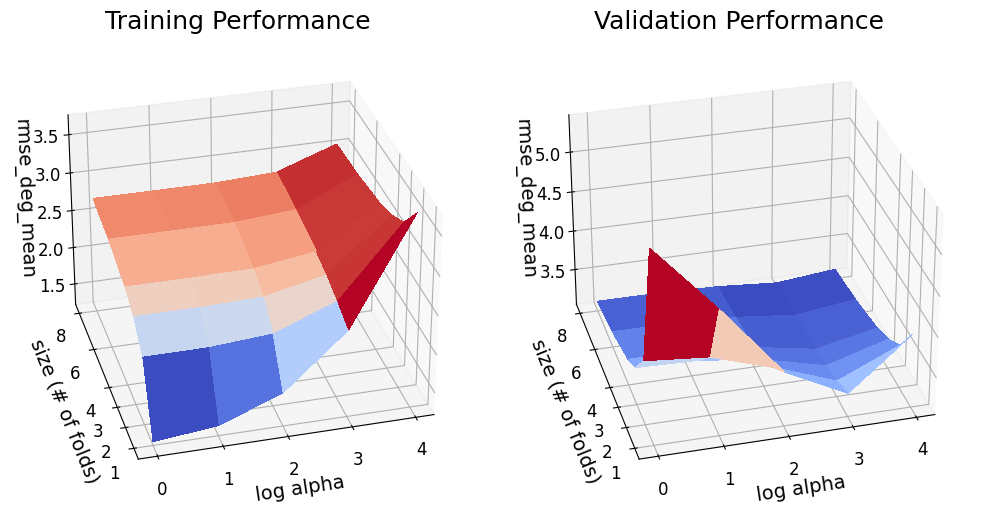

In [226]:
""" PROVIDED
RIDGE
Use plot_param_val_surface_RL() to plot the surface of the training
and validation set performance versus alpha and size.
"""
# Feel free to adjust these to understand the shape of the surface
# Elevation of the plot
elev = 30
# Angle the plot is viewed
angle = 255

# Plot
plot_param_val_surface_RL(crossval_ridge, crossval_ridge.opt_metric, 
                          ridge_alphas, elev=elev, angle=angle)

## Reflection, part 1
Give a short answer to the following questions.

### Q1: Looking at the training set performance surface plot, which alpha gives the best performance for training set size of 8 folds?

### By examining the training srt performance surface plot , The best Performance for a training set of 8 folds appears to be achieved when alpha is near 10 , it may slightly vary too.

### Q2: Looking at the validation set performance surface plot, which alpha gives the best performance for training set size of 1 fold?

### Best Performance for a training set of 1 fold achieved when aplha is 1000 or higher.

### Q3: Looking at the validation set performance surface plot, which alpha gives the best performance for training set size of 8 folds?

### For Validation set the best performance appears to be achieved when alpha is around 10.




(<Figure size 1000x600 with 1 Axes>,
 array([<Axes: title={'center': 'Validation Performance'}, xlabel='Train Set Size (# of folds)', ylabel='rmse_mean'>],
       dtype=object))

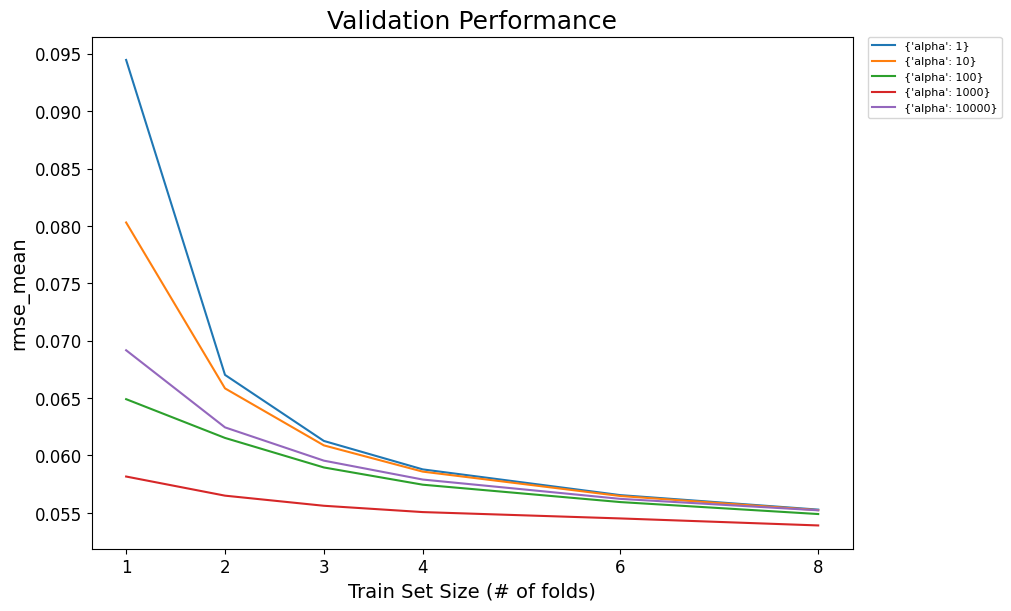

In [227]:
# DELETE

metrics_used=['rmse_mean']
crossval_ridge.plot_allparams_val(metrics_used)

In [262]:
crossval_ridge.get_best_params('rmse_mean', False)

metric list: ['mse_mean', 'mse_std', 'rmse_mean', 'rmse_std', 'rmse_deg_mean', 'rmse_deg_std', 'fvaf_mean', 'fvaf_std']


array([3, 3, 3, 3, 3, 3], dtype=int64)

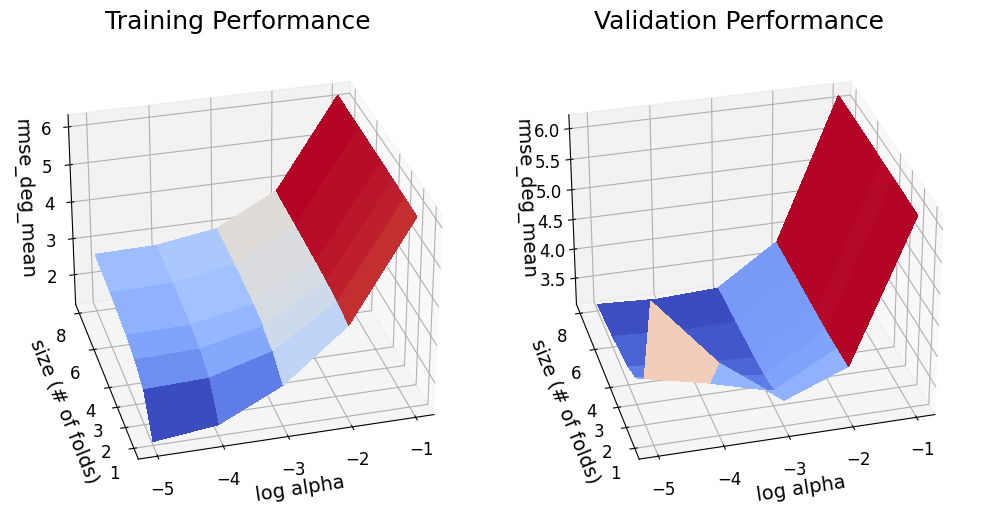

In [229]:
""" TODO
LASSO
Use plot_param_val_surface_RL() to plot the surface of the training
and validation set performance versus alpha and size.
"""
# TODO
plot_param_val_surface_RL(crossval_lasso, crossval_lasso.opt_metric, 
                          lasso_alphas, elev=elev, angle=angle)

## Reflection, part 2

Give short answers to the following questions

### Q1: For training set size 1, explain why the performance is monotonically increaseing with alpha, while validation set performance forms a U-shape.

### For Training size of 1 , as Alpha increases , the model moves from the Overfitting towards the better generalization and then towards underfitting. And the Ushape in validation performance increases in training performance reflect this behavior.


# Results: Best Parameters by Training Set Size

(<Figure size 1000x800 with 3 Axes>,
 array([<Axes: title={'center': 'train Set Performance'}, ylabel='rmse_deg_mean'>,
        <Axes: title={'center': 'val Set Performance'}, ylabel='rmse_deg_mean'>,
        <Axes: title={'center': 'test Set Performance'}, xlabel='Train Set Size (# of folds)', ylabel='rmse_deg_mean'>],
       dtype=object))

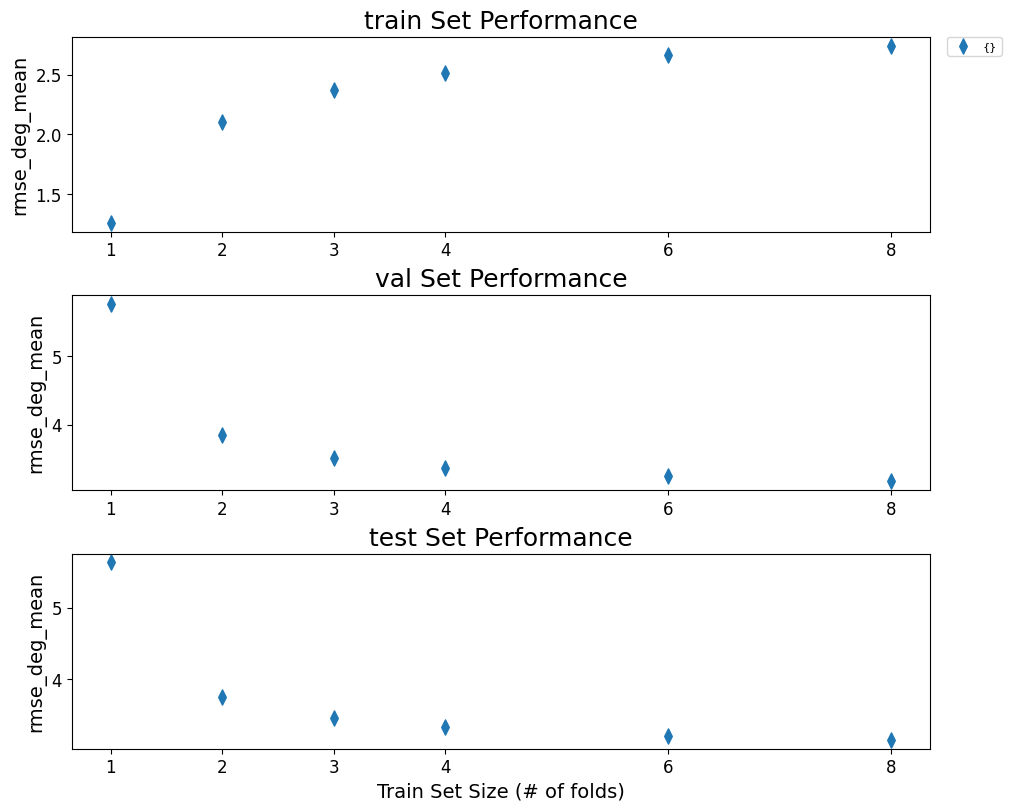

In [230]:
""" PROVIDED
LINEAR REGRESSION
Plot the mean (summary) train, validation and test set performance for 
the best hyperparameter set for each train size. Use plot_best_params_by_size()

Note: for LinearRegression, there is only one parameter set.
"""
crossval_lnr.plot_best_params_by_size() 

(<Figure size 1000x800 with 3 Axes>,
 array([<Axes: title={'center': 'train Set Performance'}, ylabel='rmse_deg_mean'>,
        <Axes: title={'center': 'val Set Performance'}, ylabel='rmse_deg_mean'>,
        <Axes: title={'center': 'test Set Performance'}, xlabel='Train Set Size (# of folds)', ylabel='rmse_deg_mean'>],
       dtype=object))

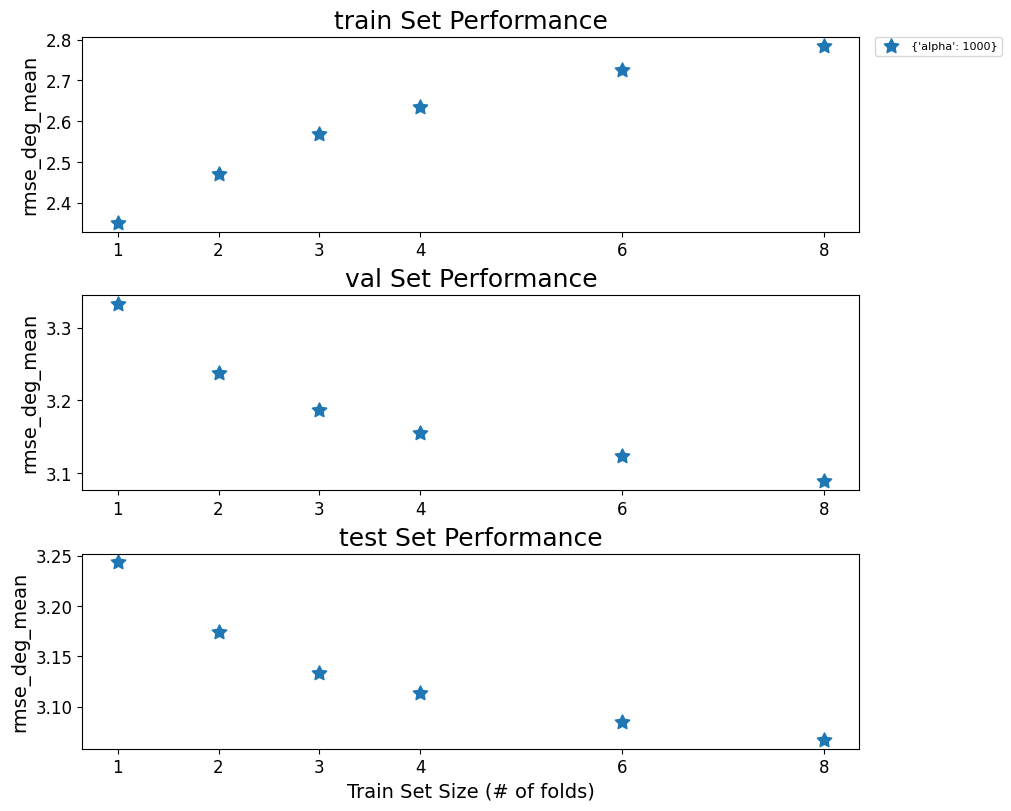

In [231]:
""" TODO

RIDGE REGRESSION

Plot the mean (summary) train and validation set performances for 
each train size for the optimized metric.

"""
# TODO
crossval_ridge.plot_best_params_by_size()

(<Figure size 1000x800 with 3 Axes>,
 array([<Axes: title={'center': 'train Set Performance'}, ylabel='rmse_deg_mean'>,
        <Axes: title={'center': 'val Set Performance'}, ylabel='rmse_deg_mean'>,
        <Axes: title={'center': 'test Set Performance'}, xlabel='Train Set Size (# of folds)', ylabel='rmse_deg_mean'>],
       dtype=object))

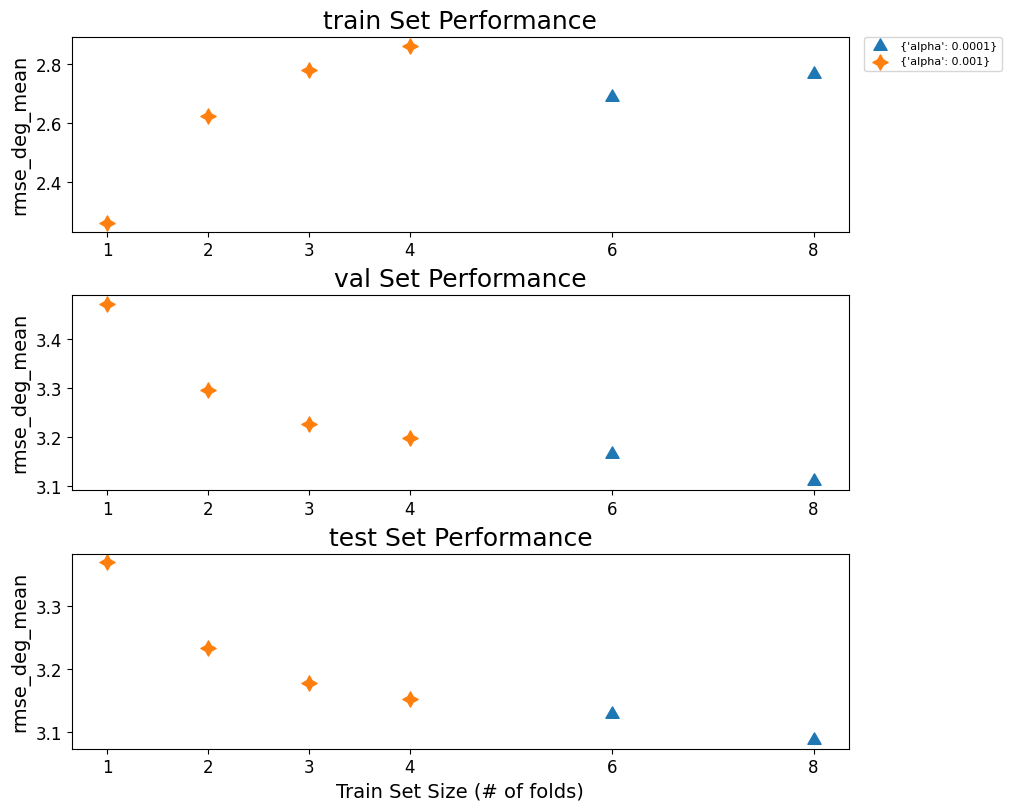

In [232]:
""" TODO

LASSO REGRESSION

Plot the mean (summary) train and validation set performances for 
each train size for the optimized metric.

"""

# TDDO
crossval_lasso.plot_best_params_by_size()


## Reflection, part 3

Give short answers to the following questions

### Q1: What is particularly striking about both the Ridge and Lasso results for this experiment?

### The results show that Lasso regression tends to perform better at smaller training sizes with a specific range of alpha values
 

# Model comparisons

    

In [233]:
""" TODO
Obtain all the "best parameter" results for all the models
"""
def extract_test_stats(cv_lnr, cv_ridge, cv_lasso, metric, size_idx):
    '''
    :param cv_lnr: Cross-Validation grid search instance for the LinearRegression model
    :param cv_ridge: Same for Ridge
    :param cv_lasso: Same for Lasso
    :param metric: Name of the metric that we are fetching from the report
    :param size_idx: Index of the training set size in the trainsizes variable.
    :return: Test set performance for the specified metric for each rotation.  
            Returns a tuple of results for LinearRegression, Ridge and Lasso
    '''
    # LinearRegression: only one set of hyper-parameters
    all_results_lnr = cv_lnr.results
    # Test set performance for training size size_idx
    test_perf_lnr = all_results_lnr[0]['results'][size_idx]['test'][metric]
    # Test set performance average across shoulder/elbow
    test_perf_avg_lnr = np.mean(test_perf_lnr, axis=1)

    # RIDGE
    all_results_ridge = cv_ridge.results
    # Best parameter set for this size_idx
    best_params_idx_ridge = cv_ridge.best_param_inds[size_idx]
    # Test set performance for training size size_idx
    test_perf_ridge = all_results_ridge[best_params_idx_ridge]['results'][size_idx]['test'][metric]
    # Test set performance average across shoulder/elbow
    test_perf_avg_ridge = np.mean(test_perf_ridge, axis=1)


    # LASSO
    # TODO
   
    all_results_lasso = cv_lasso.results
    # Best parameter set for this size_idx
    best_params_idx_lasso = cv_lasso.best_param_inds[size_idx]
    # Test set performance for training size size_idx
    test_perf_lasso = all_results_lasso[best_params_idx_lasso]['results'][size_idx]['test'][metric]
    # Test set performance average across shoulder/elbow
    test_perf_avg_lasso = np.mean(test_perf_lasso, axis=1)

    return test_perf_avg_lnr, test_perf_avg_ridge, test_perf_avg_lasso

In [234]:
# TODO: Execute the above function for rmse_deg and for a training set of 1 fold


test_lnr, test_ridge, test_lasso =  extract_test_stats(crossval_lnr, crossval_ridge, crossval_lasso, 'rmse_deg', 0)
test_lnr, test_ridge, test_lasso

(array([5.8203482 , 6.06208694, 3.66506143, 5.20470856, 5.74968991,
        7.72577095, 6.36747689, 9.71813761, 7.8055973 , 5.5433198 ,
        6.06347498, 6.99073511, 4.92382304, 4.62114199, 3.42980276,
        5.14570248, 4.72191978, 4.29414356, 3.9204434 , 4.87127865]),
 array([3.373247  , 2.48599975, 2.26466328, 2.60821692, 3.22364339,
        4.58705596, 3.95213305, 3.98249804, 5.9961264 , 3.31967151,
        3.07227249, 3.66959414, 3.04073694, 2.61849891, 2.46168611,
        2.67307742, 3.70192662, 2.7135714 , 2.72445949, 2.39716084]),
 array([3.29460359, 2.5131049 , 2.32281651, 2.71196506, 3.41017478,
        4.64635417, 4.22744596, 4.67848425, 6.0844872 , 3.40841319,
        3.25346591, 3.72309539, 2.9836382 , 2.73880838, 2.52288622,
        2.97533388, 3.77984806, 2.74108266, 2.72308646, 2.64126496]))

In [264]:
""" TODO
LinearRegression vs Lasso

Execute the paired t-test to determine whether to reject the null hypothesis 
(i.e. H0) with 95% confidence. H0 is that the mean of the distribution of the 
differences between test scores for the best LinearRegression model and the best 
Lasso is zero, when using a training size of 1 (i.e. the size at index 0 of 
the trainsizes list). Display the t-statistic, the p-value, and the mean of 
the differences e.g., mean(elastic_test_res - ridge_test_res))

Use stats.ttest_rel(). See the API reference above.
"""
#TODO
t_stat, p_val = stats.ttest_rel(test_lnr, test_lasso)

print("T-statistic:", t_stat)
print("P-value:", p_val)


T-statistic: 10.363850736193323
P-value: 2.950418493573455e-09


In [236]:
# TODO: compute the mean of the differences
# Compute the mean of the differences between test scores for Linear Regression and Lasso Regression
mean_difference = np.mean(test_lnr - test_lasso)
mean_difference


2.2632151802841802

In [266]:
""" TODO
Compare LinearRegression vs Ridge
"""
# TODO
from scipy.stats import ttest_rel

# Extract test performance for LinearRegression and Ridge
test_lnr, test_ridge, _ = extract_test_stats(crossval_lnr, crossval_ridge, crossval_lasso, 'rmse_deg', 0)

# Compute the mean difference
mean_difference = np.mean(test_lnr - test_ridge)

# Perform a paired t-test
t_stat, p_value = ttest_rel(test_lnr, test_ridge)
t_stat, p_value


(9.88395576584025, 6.349637849373387e-09)

In [238]:
# TODO: compute the mean of the differences
mean_diff = np.mean(test_lnr - test_ridge)

print(f"Mean Difference between LinearRegression and Ridge: {mean_diff:.4f}")

Mean Difference between LinearRegression and Ridge: 2.3889


In [239]:
""" TODO
Compare Lasso vs Ridge
"""
# TODO
t_stat, p_value = ttest_rel(test_lasso, test_ridge)

# Compute the mean difference between Lasso and Ridge test performances
mean_diff_lasso_ridge = np.mean(test_lasso - test_ridge)

t_stat, p_value

(3.352829160664206, 0.003342429719220317)

In [240]:
# TODO: compute the mean of the differences
mean_diff_lasso_ridge

0.1257060026163833

### Training set size 8
Repeat the above analsis with training set size 8

In [258]:
# TODO: Extract the statistics
size_idx_8 = 5
test_lnr_8, test_ridge_8, test_lasso_8 = extract_test_stats(crossval_lnr, crossval_ridge, crossval_lasso, 'rmse_deg', size_idx_8)
test_lnr_8, test_ridge_8, test_lasso_8

(array([3.14365489, 2.69786272, 2.70974747, 2.95374736, 3.32535626,
        4.3522652 , 3.82207922, 3.60517724, 5.70481447, 3.10221817,
        2.87271422, 3.26069597, 2.72747824, 2.54701202, 2.41122627,
        2.35671833, 3.60455875, 2.63274966, 2.6111719 , 2.46740956]),
 array([3.02910098, 2.55069132, 2.52840492, 2.79084925, 3.1218028 ,
        4.25067089, 3.79458351, 3.54475134, 5.72112928, 3.09611076,
        2.82415688, 3.28411743, 2.65935805, 2.46503445, 2.35119991,
        2.30729832, 3.57861354, 2.55248854, 2.54251129, 2.34340229]),
 array([3.06047855, 2.59327543, 2.60448726, 2.88051183, 3.20807609,
        4.28056707, 3.80277957, 3.52351251, 5.7035222 , 3.08961035,
        2.83277614, 3.25441712, 2.66421073, 2.48845331, 2.37773032,
        2.3230447 , 3.58431837, 2.57765073, 2.54206481, 2.36352068]))

In [251]:
# TODO: Compare LinearRegression vs Ridge
t_stat_lin_ridge, p_val_lin_ridge = ttest_rel(test_lnr_8, test_ridge_8)
t_stat_lin_ridge, p_val_lin_ridge

(5.612280112120502, 2.0638307047213895e-05)

In [252]:
# TODO: compute the mean of the differences
mean_diff_lin_ridge = np.mean(test_lnr_8 - test_ridge_8)
mean_diff_lin_ridge 

0.07861910983196689

In [253]:
# TODO: Compare LinearRegression vs Lasso
t_stat_lin_lasso, p_val_lin_lasso = ttest_rel(test_lnr_8, test_lasso_8)
t_stat_lin_lasso, p_val_lin_lasso

(7.229880361218775, 7.284671735868056e-07)

In [255]:
# TODO: compute the mean of the differences
mean_diff_lin_lasso = np.mean(test_lnr_8 - test_lasso_8)
mean_diff_lin_lasso


0.05768250796690262

In [256]:
""" TODO
Compare Lasso vs Ridge
"""
# TODO
t_stat_lasso_ridge, p_val_lasso_ridge = ttest_rel(test_lasso_8, test_ridge_8)
t_stat_lasso_ridge, p_val_lasso_ridge

(2.842382776291314, 0.010414348233567768)

In [257]:
# TODO: compute the mean of the differences
mean_diff_lasso_ridge = np.mean(test_lasso_8 - test_ridge_8)
mean_diff_lasso_ridge

0.020936601865064276

# Reflection, part 4

Give short answers to the following questions.  
* You may ignore issues of multiple comparisons for this analysis
* Remember to report p-values as "p < SOME_VALUE" (it is not technically equal the way we are asking the significance question)
* When you are reporting p-values, you may always round them up to make the values shorer.  For example, you may transform p < .003911232 into p < .004.  However, be careful not to round across the critical alpha value.

### Q1: For training set size of 1, is there a statistically significant "best" model among the three?

### For the Training set size of 1 , The statistically significant "Best Model " among the threes is Linear Model because its pvalue is better , because 
### Linear Regression vs Lasso , P-value: 2.9504×10 −9
### Linear Regression vs Ridge, P-value : 6.3496×10 −9


### Q2: For training set size of 8, is there a statistically significant "best" model among the three?

### For the Training set size of 8 , The statistically significant "Best Model " among the threes is Linear Model because when we compared with other models it seems to be best as
### Linear vs Ridge ; p = 2.0638307047213895×10−5
### Linear vs Lasso ; p =7.284671735868056×10 −7
### Q3: For training set size of 8, is there a meaningfully "best" model among the three?

### For training set size of 8, is there a meaningfully "best" model among the three is Linear model is best.
